In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# 학습데이터 구성 및 전처기
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# Xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

# XAI
import shap

# 학습 데이터 원천
from ucimlrepo import fetch_ucirepo

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [6]:
# 데이터 로드
# https://archive.ics.uci.edu/dataset
wine_quality = fetch_ucirepo(id=186)
wine_quality

{'data': {'ids': None,
  'features':       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
  0               7.4              0.70         0.00             1.9      0.076   
  1               7.8              0.88         0.00             2.6      0.098   
  2               7.8              0.76         0.04             2.3      0.092   
  3              11.2              0.28         0.56             1.9      0.075   
  4               7.4              0.70         0.00             1.9      0.076   
  ...             ...               ...          ...             ...        ...   
  6492            6.2              0.21         0.29             1.6      0.039   
  6493            6.6              0.32         0.36             8.0      0.047   
  6494            6.5              0.24         0.19             1.2      0.041   
  6495            5.5              0.29         0.30             1.1      0.022   
  6496            6.0              0.21         0.38

In [7]:
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
# dataset 에 대한 정보
print(wine_quality.metadata)
# variable 에 대한 정보
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [8]:
# EDA (탐색적 데이터 분석)
print("Data shape", X.shape)
print("Target Distribution: \n", y.value_counts())

Data shape (6497, 11)
Target Distribution: 
 quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


In [9]:
df = X
df['target'] = y

/var/folders/nj/n9vs0lfn21sd400872cqpsz00000gn/T/ipykernel_9093/3121753340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = y


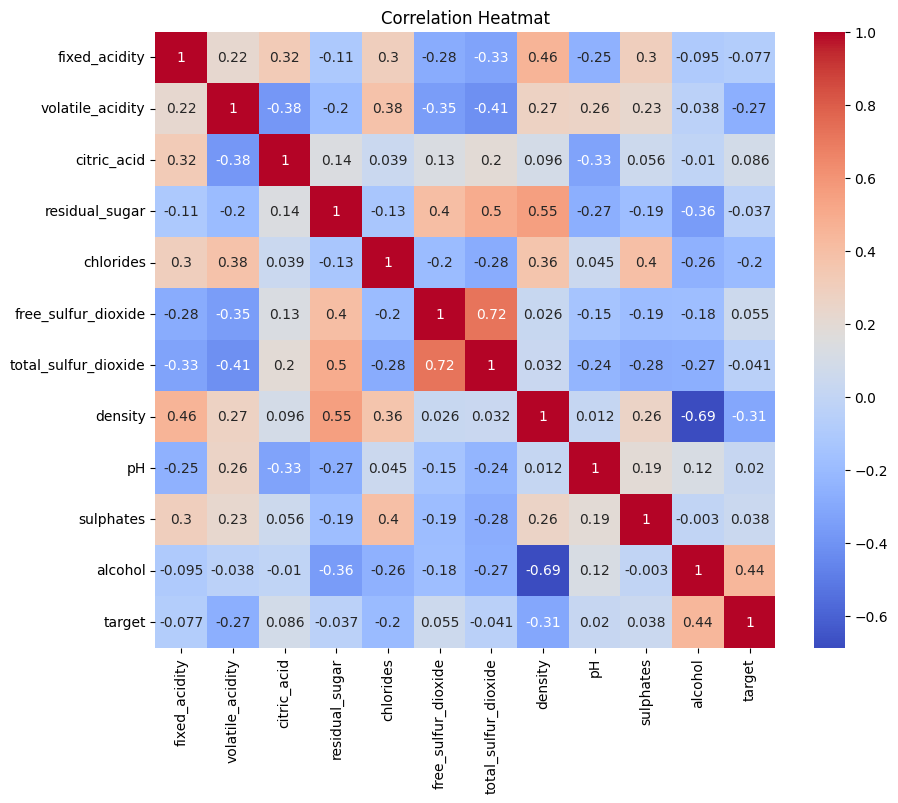

In [10]:
# 히트맵 시각화
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmat")
plt.show()

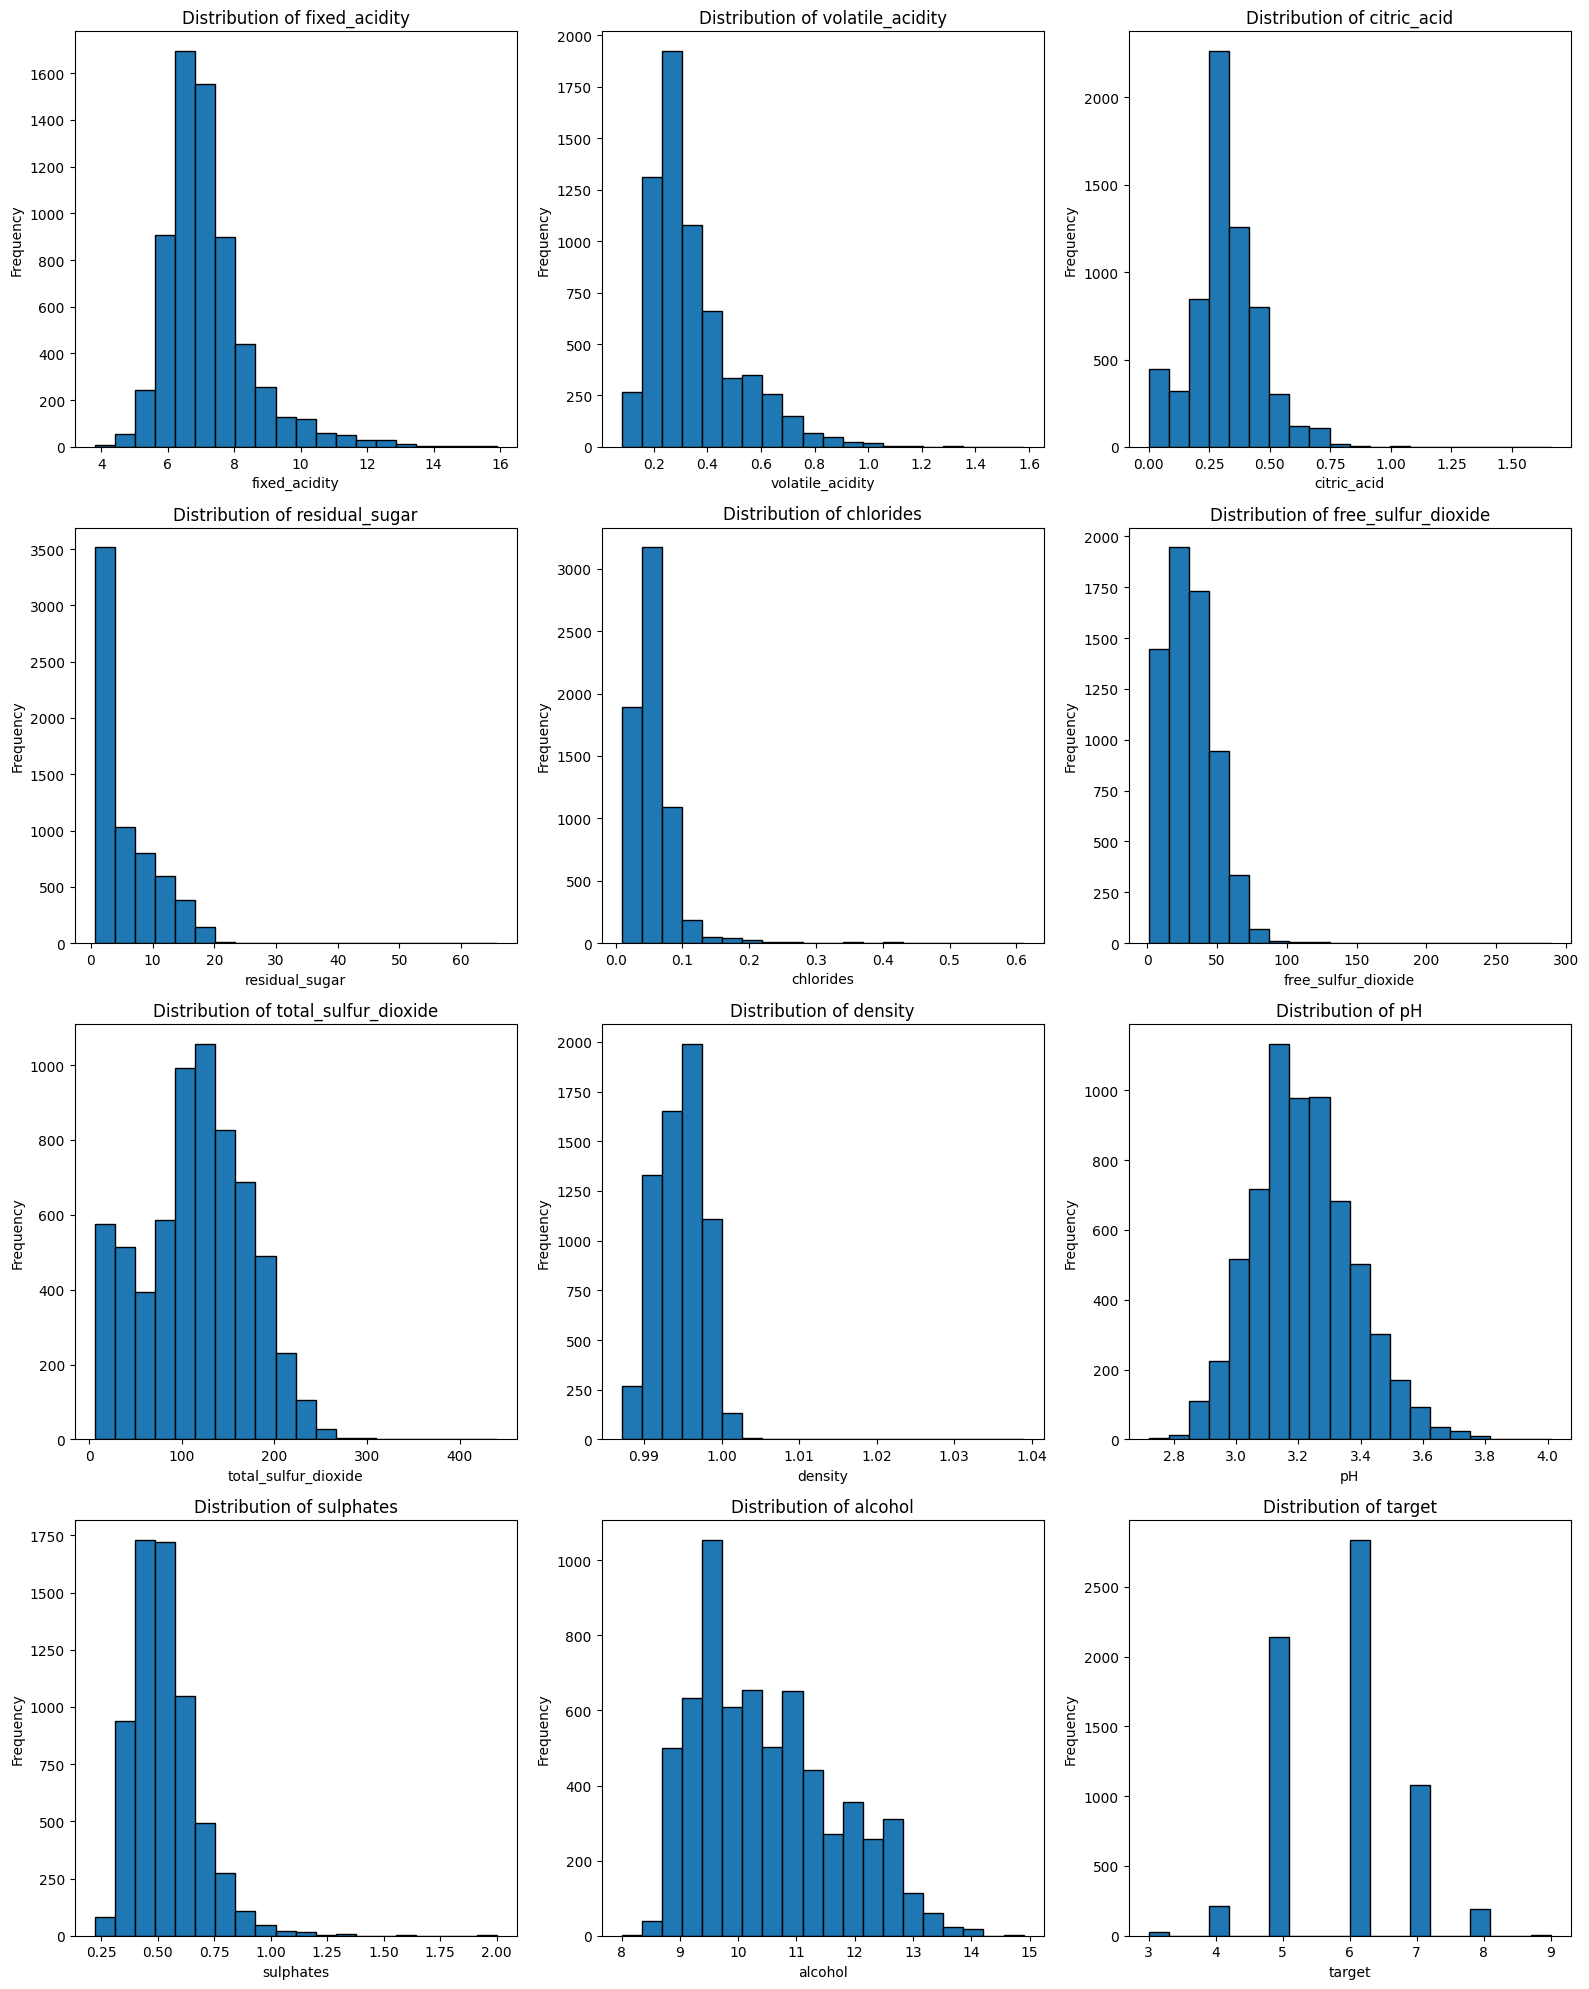

In [14]:
# Feature 분포 시각화
plt.figure(figsize=(16, 20))

for i, feature in enumerate(X.columns):
    plt.subplot(4, 3, i+1)
    plt.hist(X[feature], bins = 20, edgecolor='black' )
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

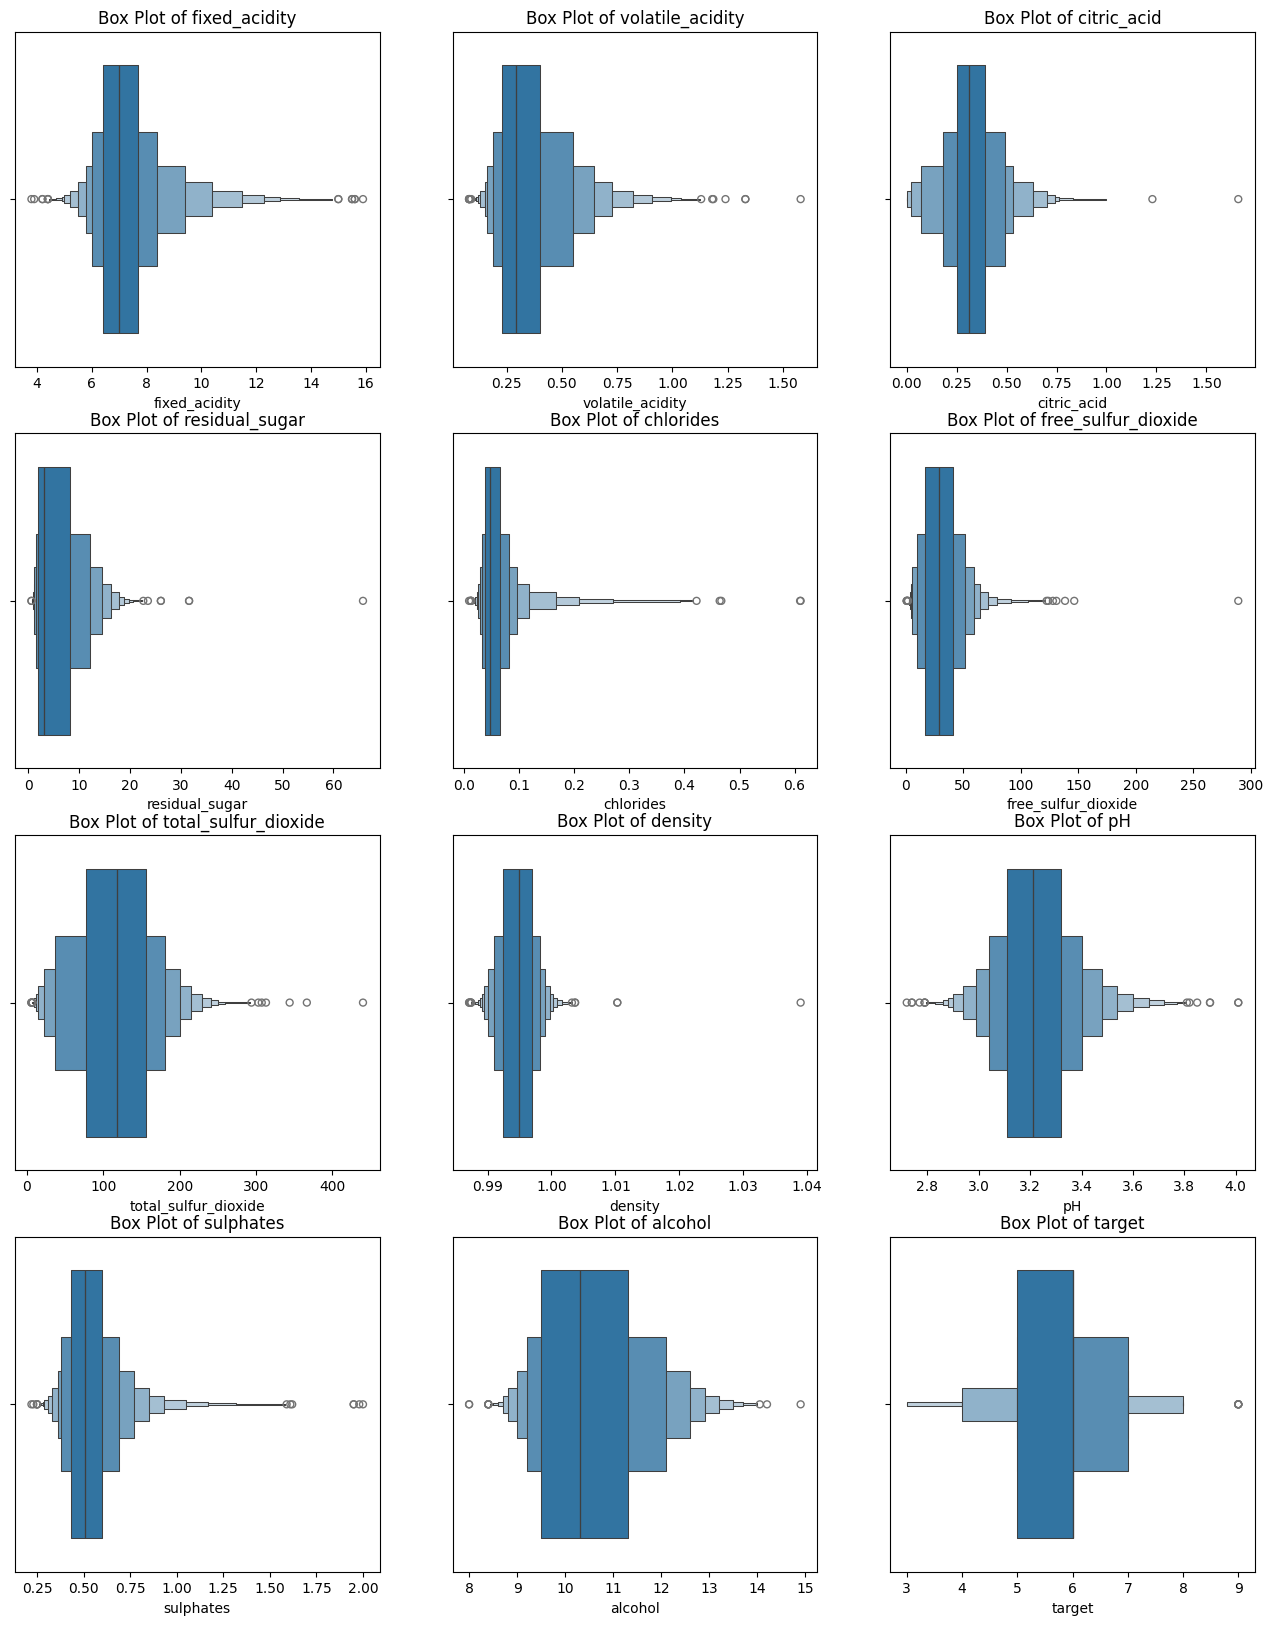

In [16]:
# Box-plot
plt.figure(figsize=(16, 20))

for i, feature in enumerate(X.columns):
    plt.subplot(4, 3, i+1)
    sns.boxenplot(x=X[feature])
    plt.title(f"Box Plot of {feature}")

plt.tight_layout
plt.show()

In [17]:
x = df.drop('target', axis = 1)

In [18]:
# 데이터 전처리
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# 데이터 불할
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [23]:
# 클래스 레이블 확인
unique_labels = np.unique(y)
print(unique_labels)

[3 4 5 6 7 8 9]


In [26]:
# 레이블링 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [27]:
y_train_encoded

array([2, 4, 3, ..., 2, 2, 2], shape=(5197,))

In [28]:
# Random Forest 모델 생성 및 학습

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train_encoded)

RandomForestClassifier(random_state=42)

In [ ]:
# Random Forest 모델 예측
rf_y_pred_encoded = rf_model.predict(X_test)
rf_y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.71      0.12      0.20        43
           5       0.67      0.71      0.69       402
           6       0.66      0.76      0.71       597
           7       0.72      0.55      0.62       215
           8       0.92      0.33      0.49        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.53      0.35      0.39      1300
weighted avg       0.68      0.67      0.66      1300



/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [ ]:
# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [32]:
# 예측 및 레이블 디코딩
rf_y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.42      0.19      0.26        43
           5       0.66      0.71      0.68       402
           6       0.67      0.73      0.70       597
           7       0.65      0.57      0.61       215
           8       0.72      0.36      0.48        36
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.45      0.36      0.39      1300
weighted avg       0.65      0.66      0.65      1300



/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [41]:
print('XGBoost Hyperparameters:')
print(xgb_model.get_params())

pprint.pprint(xgb_model.get_params())

XGBoost Hyperparameters:
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
{'base_score': None,
 'booster': None,
 'callbacks': 

In [ ]:
# 하이퍼파라미터 범위지정

params = {
    "max_depth" : [3, 5, 7, 9, 15],
    "learning_rate" : [0.1, 0.01, 0.001],
    "n_estimators" : [50, 100, 200, 300]
}

In [46]:
# 하이퍼파라미터 최적화
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv = 5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200}
Best accuracy: 0.6638468942030059


In [48]:
## 최적의 하이퍼파라미터의 학습
best_model = grid_search.best_estimator_

# 테스트 데이터에 대한 예측
y_pred_encoded = best_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.56      0.23      0.33        43
           5       0.67      0.69      0.68       402
           6       0.66      0.74      0.69       597
           7       0.69      0.56      0.62       215
           8       0.78      0.39      0.52        36
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.48      0.37      0.41      1300
weighted avg       0.66      0.66      0.66      1300



/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (12).

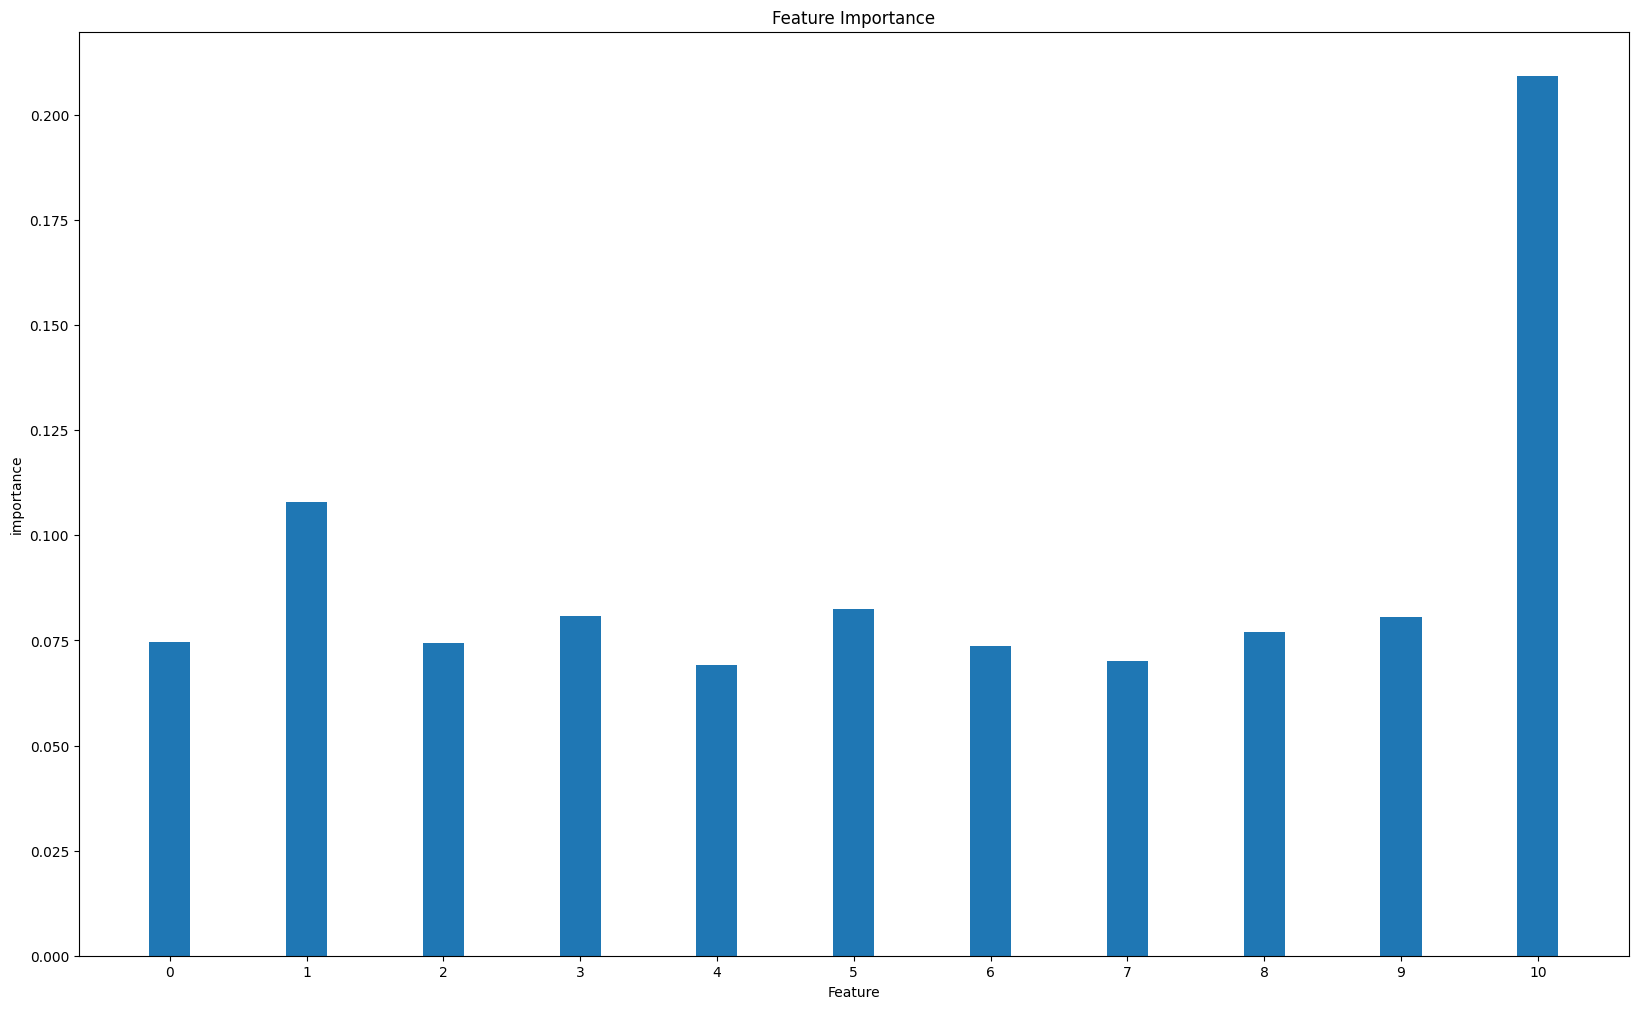

In [50]:
# XAI 
# Feature Importance 시각화
importances = best_model.feature_importances_

plt.figure(figsize=(20,12))
# 막대그래프 생성
plt.bar(range(len(importances)), importances, width=0.3)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Feature Importance')
plt.xticks(range(len(importances)), X.columns, rotation=45)
plt.show()

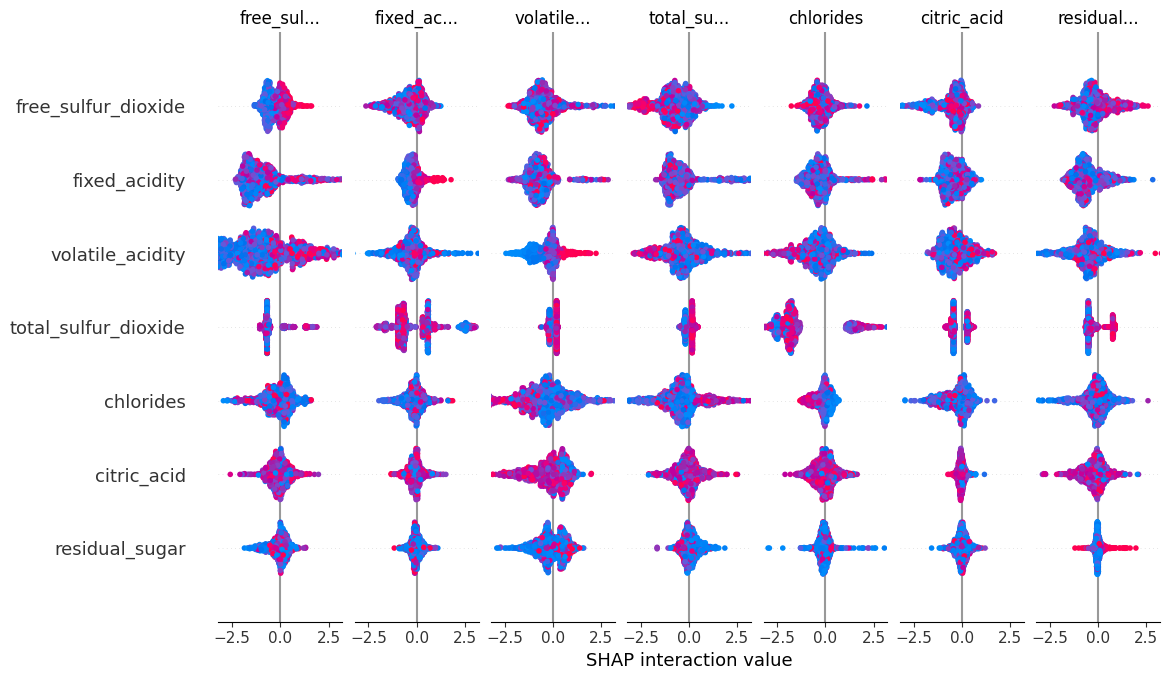

In [57]:
# XAI
# SHAP(Shapley Additive Explanations)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

/Users/lsm/ai/ai-portfolio/ml/.venv/lib/python3.13/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


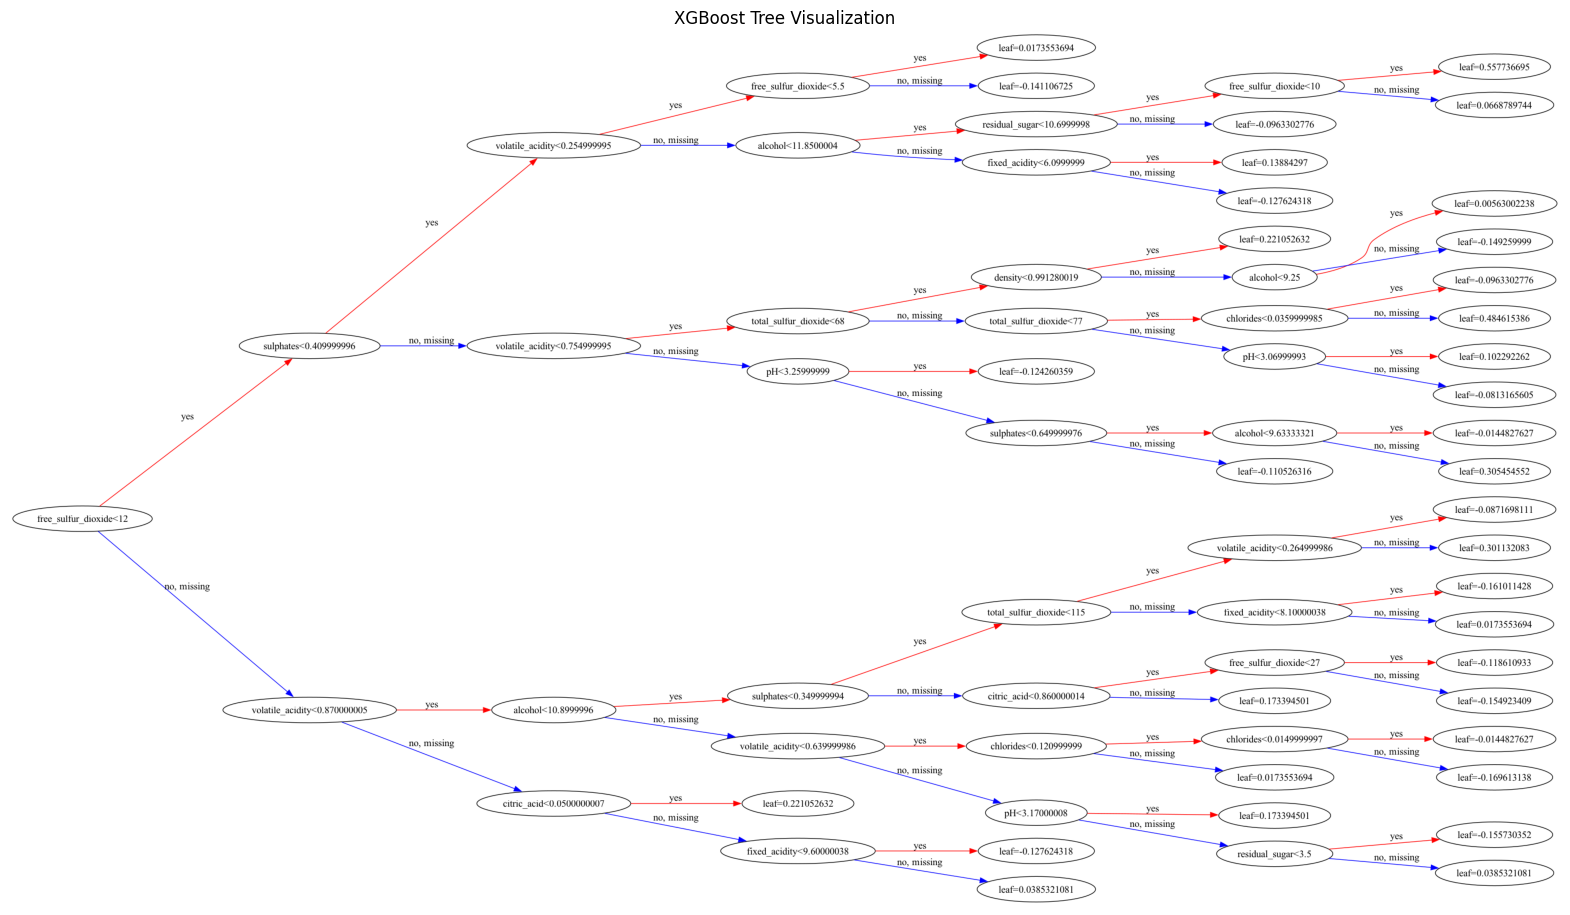

In [59]:
# XGboost 트리 시각화

fig, ax = plt.subplots(figsize = (20, 20))
plot_tree(xgb_model, num_trees=1, rankdir='LR', ax=ax)

plt.title("XGBoost Tree Visualization")
plt.show()